In [0]:
!git clone https://github.com/genn-team/genn.git --branch 4.1.0

fatal: destination path 'genn' already exists and is not an empty directory.


In [0]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import os
os.environ['CUDA_PATH'] ='/usr/local/cuda'

In [0]:
os.chdir('genn/')
!make DYNAMIC=1 LIBRARY_DIRECTORY=`pwd`/pygenn/genn_wrapper/

make -C src/genn/genn
make[1]: Entering directory '/content/genn/src/genn/genn'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/genn/src/genn/genn'
make -C src/genn/backends/single_threaded_cpu
make[1]: Entering directory '/content/genn/src/genn/backends/single_threaded_cpu'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/genn/src/genn/backends/single_threaded_cpu'
make -C src/genn/backends/cuda
make[1]: Entering directory '/content/genn/src/genn/backends/cuda'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/genn/src/genn/backends/cuda'


In [0]:
!python setup.py develop

running develop
running egg_info
writing pygenn.egg-info/PKG-INFO
writing dependency_links to pygenn.egg-info/dependency_links.txt
writing requirements to pygenn.egg-info/requires.txt
writing top-level names to pygenn.egg-info/top_level.txt
writing manifest file 'pygenn.egg-info/SOURCES.txt'
running build_ext
building '_StlContainers' extension
swigging pygenn/genn_wrapper/generated/StlContainers.i to pygenn/genn_wrapper/generated/StlContainers_wrap.cpp
swig -python -c++ -relativeimport -outdir /content/genn/pygenn/genn_wrapper -I/content/genn/pygenn/genn_wrapper/include -I/content/genn/pygenn/genn_wrapper/generated -I/content/genn/pygenn/genn_wrapper/swig -py3 -o pygenn/genn_wrapper/generated/StlContainers_wrap.cpp pygenn/genn_wrapper/generated/StlContainers.i
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/content/genn/pygenn/genn_wrapper/include -I/content/genn/pygenn/ge

# **IMPORTS**

In [0]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from pygenn import genn_model, genn_wrapper 

# **CODE**

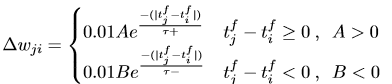

To obtain anti-Hebbian STDP, we swap the cases



In this example, we will be implementing STDP-Anti-Hebbian Learning with the same apparatus as the previous tutorial:

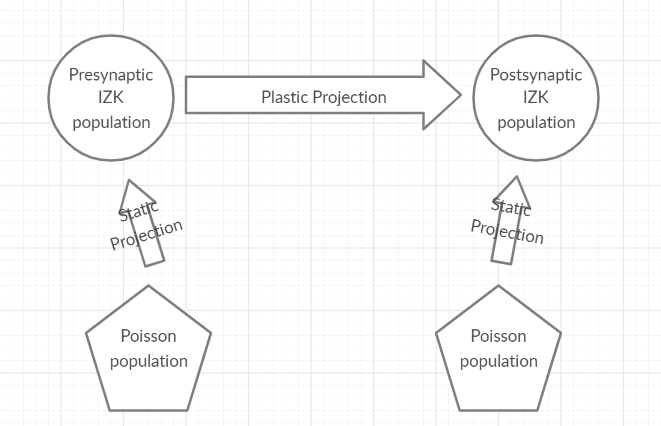



Building Model
Loading Model
Weight Initial
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Weight Final
[0.09346254 0.02467413 0.07890688 0.01388409 0.05072699 0.0758065
 0.01       0.02975672 0.06770499 0.05610808 0.06216387 0.04502577
 0.07286117 0.06570293 0.0413895  0.04312715 0.0354982  0.0251862
 0.04728395 0.01       0.01       0.03869099 0.01280765 0.02594556
 0.01       0.08043516 0.01       0.01       0.01       0.03735058
 0.09996531 0.1        0.08266645 0.01       0.01       0.07189906
 0.02230103 0.01       0.0300494  0.05193384 0.1        0.09918109
 0.06557389 0.05910557 0.08       0.0307933  0.04661227 0.01931943
 0.0540568  0.01384582 0.04678367 0.01       0.01413186 0.01834795
 0.02876027 0.06556598 0.07222174 0.

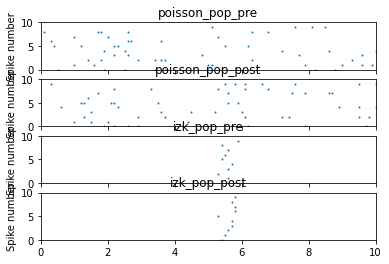

In [0]:
# ********************************************************************************
#                      Model Definitions
# ********************************************************************************

# Anti-Hebbian
stdp_model_anti_Hebbian = genn_model.create_custom_weight_update_class(
    "stdp_model_anti_Hebbian",
    param_names=["tauMinus", "tauPlus", "A", "B","gMax","gMin"],
    var_name_types=[("g", "scalar")],
    sim_code=
        """
        $(addToInSyn, $(g));
        scalar dt = $(t) - $(sT_post);
        if(dt > 0) {
          scalar timing = exp(-dt / $(tauPlus));
          scalar newWeight = $(g) + ($(A) * timing);
          $(g) = fmin($(gMax), newWeight);
        }
        """,
    learn_post_code=
        """
        scalar dt = $(t) - $(sT_pre);
        if (dt > 0) {
          scalar timing = exp(-dt / $(tauMinus));
          scalar newWeight = $(g) - ($(B) * timing);
          $(g) = fmax($(gMin), newWeight);
        }
        """,

    is_pre_spike_time_required=True,
    is_post_spike_time_required=True
)



# ********************************************************************************
#                      Parameters and Hyperparameters
# ********************************************************************************

# Hyperparameters
# Global 
timestep = 0.1


# Neuron
n_pop = 10

# Parameters and initial values
izk_init = {"V": -70.0,
            "U": -20.0,
            "a": 0.02,
            "b": 0.2,
            "c": -65.0,
            "d": 8.0}

stdp_init = {"g":genn_model.init_var("Uniform",{"min":0.01, "max":0.1})}

stdp_params = {"tauMinus": 20.0, "tauPlus": 20.0, "A":0.02, "B":0.02, "gMax": 0.1, "gMin":0.01}


# ----------------------------------------------------------------------------
#                       Custom GeNN models
# ----------------------------------------------------------------------------

model = genn_model.GeNNModel("float","stdp_example")


# Neuron populations

poisson_pop_pre = model.add_neuron_population("poisson_pop_pre",n_pop,"PoissonNew",{"rate":500},{'timeStepToSpike':0.0})
poisson_pop_post = model.add_neuron_population("poisson_pop_post",n_pop,"PoissonNew",{"rate":500},{'timeStepToSpike':0.0})


izk_pop_pre = model.add_neuron_population("izk_pop_pre", n_pop, "IzhikevichVariable", {}, izk_init)

izk_pop_post = model.add_neuron_population("izk_pop_post", n_pop, "IzhikevichVariable", {}, izk_init)

neuron_layers = [poisson_pop_pre,poisson_pop_post,izk_pop_pre,izk_pop_post]

#Create synaptic connections between neuronal populations
syn_pi_pop = model.add_synapse_population("syn_pi_pop","SPARSE_INDIVIDUALG",genn_wrapper.NO_DELAY,  
    poisson_pop_pre,izk_pop_pre,"StaticPulse", {}, {"g": 5.0}, {}, {},
        "DeltaCurr", {}, {},genn_model.init_connectivity("OneToOne",{}))

syn_po_pop = model.add_synapse_population("syn_po_pop","SPARSE_INDIVIDUALG",genn_wrapper.NO_DELAY,
    poisson_pop_post,izk_pop_post,"StaticPulse", {}, {"g": 5.0}, {}, {},
        "DeltaCurr", {}, {},genn_model.init_connectivity("OneToOne",{}))

syn_io_pop = model.add_synapse_population("syn_io_pop","DENSE_INDIVIDUALG",genn_wrapper.NO_DELAY,
    izk_pop_pre,izk_pop_post,stdp_model_anti_Hebbian,stdp_params,stdp_init,{},{},
        "DeltaCurr", {}, {})



# ********************************************************************************
#                      Building and Simulation
# ********************************************************************************

PRESENT_TIMESTEPS = 100.0
TIMESTEP = 0.1

n_stim_test = 5
n_stim_pairing = 20
dur_stim = 20


ISI = 90
start_test_pre_pairing = 200
start_pairing = 1500
start_test_post_pairing = 700

simtime = (start_pairing + start_test_post_pairing + ISI*(n_stim_pairing+n_stim_test) + 550.)


  

# Simulate
model.dT = 0.1
print("Building Model")
model.build()
print("Loading Model")
model.load()


weight_initial = syn_io_pop.get_var_values('g')

layer_spikes = [(np.empty(0), np.empty(0)) for _ in enumerate(neuron_layers)]



while model.timestep < simtime:
    
    # Loop through neuron layers
    for i, l in enumerate(neuron_layers):
        # Download spikes
        model.pull_current_spikes_from_device(l.name)

        # Add to data structure
        spike_times = np.ones_like(l.current_spikes) * model.t
        layer_spikes[i] = (np.hstack((layer_spikes[i][0], l.current_spikes)),
                           np.hstack((layer_spikes[i][1], spike_times)))
    
    model.step_time()
    

model.pull_var_from_device('syn_io_pop','g')
weight_final = syn_io_pop.get_var_values('g')
print("Weight Initial")
print(weight_initial)
print("Weight Final")
print(weight_final)

# ----------------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Create a plot with axes for each
fig, axes = plt.subplots(len(neuron_layers), sharex=True)


# Loop through axes and their corresponding neuron populations
for a, s, l in zip(axes, layer_spikes, neuron_layers):
    # Plot spikes
    a.scatter(s[1], s[0], s=1)

    # Set title, axis labels
    a.set_title(l.name)
    a.set_ylabel("Spike number")
    a.set_xlim((0, PRESENT_TIMESTEPS * TIMESTEP))
    a.set_ylim((0, l.size))



# Show plot
plt.show()







Building Model
Loading Model
Weight Initial
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Weight Final
[0.01       0.03767699 0.04610763 0.03818747 0.06530488 0.05620966
 0.05165071 0.03571283 0.03989675 0.01804416 0.07120116 0.06823379
 0.01189565 0.07246496 0.05563186 0.02675812 0.1        0.04196724
 0.04208727 0.01       0.02610565 0.05494666 0.07377611 0.05894674
 0.01       0.04879112 0.1        0.0737783  0.06258966 0.0957591
 0.01       0.06879537 0.06499119 0.01014951 0.01188631 0.0132965
 0.07616856 0.03401649 0.04544874 0.02686839 0.07661788 0.03986685
 0.0261728  0.02039174 0.01924643 0.0805609  0.0380724  0.05111465
 0.07942466 0.01       0.1        0.03555642 0.034869   0.1
 0.1        0.1        0.1        0.0853212

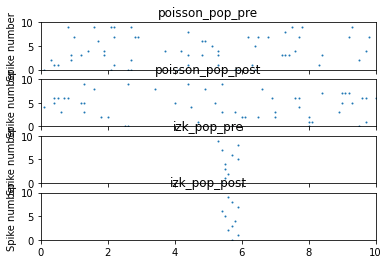